# This is the GPU KMEANS recipe for task2

In [1]:
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy import stats
import os
import torch
import numpy as np
import random
import sys
import sklearn.metrics.pairwise as pdist
import sklearn.metrics as skmetrics
import sklearn.cluster as skcluster
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # appoint GPU devices

random.seed(3007)

In [2]:
# Choosing `num_centers` random data points as the initial centers
def random_init(dataset, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    used = torch.zeros(num_points, dtype=torch.long)
    indices = torch.zeros(num_centers, dtype=torch.long)
    for i in range(num_centers):
        while True:
            cur_id = random.randint(0, num_points - 1)
            if used[cur_id] > 0:
                continue
            used[cur_id] = 1
            indices[i] = cur_id
            break
    indices = indices.to(device_gpu)
    centers = torch.gather(dataset, 0, indices.view(-1, 1).expand(-1, dimension))
    return centers

# Compute for each data point the closest center
def compute_codes(dataset, centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    num_centers = centers.size(0)
    # 5e8 should vary depending on the free memory on the GPU
    # Ideally, automatically ;)
    chunk_size = int(5e8 / num_centers)
    codes = torch.zeros(num_points, dtype=torch.long, device=device_gpu)
    centers_t = torch.transpose(centers, 0, 1)
    centers_norms = torch.sum(centers ** 2, dim=1).view(1, -1)
    for i in range(0, num_points, chunk_size):
        begin = i
        end = min(begin + chunk_size, num_points)
        dataset_piece = dataset[begin:end, :]
        dataset_norms = torch.sum(dataset_piece ** 2, dim=1).view(-1, 1)
        distances = torch.mm(dataset_piece, centers_t)
        distances *= -2.0
        distances += dataset_norms
        distances += centers_norms
        _, min_ind = torch.min(distances, dim=1)
        codes[begin:end] = min_ind
    return codes

# Compute new centers as means of the data points forming the clusters
def update_centers(dataset, codes, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    centers = torch.zeros(num_centers, dimension, dtype=torch.float, device=device_gpu)
    cnt = torch.zeros(num_centers, dtype=torch.float, device=device_gpu)
    centers.scatter_add_(0, codes.view(-1, 1).expand(-1, dimension), dataset)
    cnt.scatter_add_(0, codes, torch.ones(num_points, dtype=torch.float, device=device_gpu))
    # Avoiding division by zero
    # Not necessary if there are no duplicates among the data points
    cnt = torch.where(cnt > 0.5, cnt, torch.ones(num_centers, dtype=torch.float, device=device_gpu))
    centers /= cnt.view(-1, 1)
    return centers

def cluster(dataset, num_centers):
    centers = random_init(dataset, num_centers)
    print(centers)
    codes = compute_codes(dataset, centers)
    num_iterations = 0
    while True:
        sys.stdout.write('.')
        sys.stdout.flush()
        num_iterations += 1
        centers = update_centers(dataset, codes, num_centers)
        new_codes = compute_codes(dataset, centers)
        # Waiting until the clustering stops updating altogether
        # This is too strict in practice
        if torch.equal(codes, new_codes):
            sys.stdout.write('\n')
            print('Converged in %d iterations' % num_iterations)
            break
        codes = new_codes
    return centers, codes

def length_norm(mat):
    return mat / np.sqrt(np.sum(mat * mat, axis=1))[:, None]

## Step 1. Load speaker embeddings of FFSVC2020 supplement set 

In [ ]:
model_dir ='PATH_MODEL' # the speaker embedding save in the PATH_MODEL dir,

In [4]:
from scipy.spatial.distance import cdist
embd_dict = np.load('../exp/%s/PATH_of_FFSVC20_SUPPLEMENTARY_EMBEDDINGS.npy'%model_dir, allow_pickle=True)

com_vos_embd = []
com_vos_embd_idx = []

for num,utt in enumerate(embd_dict.item()):
    com_vos_embd.append(embd_dict.item().get(utt))
    com_vos_embd_idx.append(num)
    
com_vos_embd =  np.squeeze(np.array(com_vos_embd))
com_vos_embd = length_norm(com_vos_embd)
print(com_vos_embd.shape)

device_gpu = torch.device('cuda')
dataset = torch.from_numpy(com_vos_embd.astype(np.float32)).to(device_gpu)


(823726, 256)


## Step 2. KMEANS Cluster

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

num_classin_centers_loss=[]
num_classout_centers_loss=[]
std_loss=[]
silhouette_score_loss=[]
distortions = []

codesori_dict_round1={}
centersori_dict_round1={}
spk_inclass_dis={}

with torch.no_grad():
    for num_centers in range(10,2000,10):
        centersori, codesori = cluster(dataset, num_centers)
        codesori_dict_round1[num_centers]=codesori
        centersori_dict_round1[num_centers]=centersori
        
        loss_classin_total=0
        loss_classout_total=0
        in_std = 0
        for tmp_num in range(num_centers):
            idx = (codesori==tmp_num).nonzero()
            if len(idx)==1:
                cos_mat = (centersori[tmp_num].unsqueeze(0) @ dataset[idx].squeeze(1).T)/(torch.norm(dataset[idx]) * torch.norm(centersori[tmp_num]))
                loss_classin_total +=  cos_mat.mean()
            else:
                cos_mat = (centersori[tmp_num].unsqueeze(0) @ dataset[idx].squeeze().T)/(torch.norm(dataset[idx].squeeze(),dim=1) * torch.norm(centersori[tmp_num]))
                loss_classin_total +=  cos_mat.mean()

#         print(loss_classin_total)
        print("num_centers %s, classin loss is %s" %(num_centers, loss_classin_total/num_centers))
        num_classin_centers_loss.append(loss_classin_total/num_centers)


tensor([[-0.0363, -0.1566,  0.0134,  ..., -0.0982,  0.0045, -0.0172],
        [-0.0348, -0.1278,  0.0062,  ...,  0.0161,  0.0864,  0.0233],
        [ 0.0765,  0.0140,  0.0376,  ..., -0.0090, -0.0491,  0.0910],
        ...,
        [-0.0660,  0.0640, -0.1019,  ..., -0.0688,  0.0075, -0.0648],
        [-0.0255, -0.0588,  0.0961,  ...,  0.0453,  0.0712,  0.1183],
        [-0.0413,  0.0315, -0.0079,  ..., -0.0906,  0.0568, -0.0435]],
       device='cuda:0')
...........................................................................................................................
Converged in 123 iterations
num_centers 10, classin loss is tensor(0.5707, device='cuda:0')
tensor([[ 0.0374,  0.0761,  0.0219,  ...,  0.0299, -0.0522,  0.0561],
        [-0.0008,  0.0574, -0.0017,  ..., -0.0495,  0.0276,  0.0692],
        [-0.0016,  0.0119, -0.0375,  ..., -0.0912, -0.0481, -0.0539],
        ...,
        [ 0.0342,  0.0595, -0.0048,  ...,  0.0991, -0.0151,  0.0380],
        [-0.0055,  0.0375,  0.056

..................................................................................................
Converged in 98 iterations
num_centers 120, classin loss is tensor(0.7130, device='cuda:0')
tensor([[ 0.0207, -0.0102, -0.0031,  ...,  0.0039,  0.0988,  0.1172],
        [ 0.0002, -0.0008,  0.0136,  ...,  0.0485,  0.0187,  0.1138],
        [ 0.0207, -0.0013,  0.0222,  ...,  0.0865, -0.0719, -0.0173],
        ...,
        [-0.0568, -0.0624, -0.1039,  ...,  0.0143, -0.0273,  0.0212],
        [-0.1184, -0.1036,  0.0317,  ..., -0.0217,  0.1257,  0.0094],
        [-0.0724, -0.0516, -0.0608,  ..., -0.0410,  0.0572, -0.0198]],
       device='cuda:0')
......................................................................................................................................
Converged in 134 iterations
num_centers 130, classin loss is tensor(0.7162, device='cuda:0')
tensor([[ 0.0373, -0.0936,  0.0018,  ..., -0.0001,  0.0022,  0.0191],
        [-0.0686, -0.0594,  0.0034,  ..., -0.0081,  0

................................................................................................................................................................................................................................................................
Converged in 256 iterations
num_centers 230, classin loss is tensor(0.7316, device='cuda:0')
tensor([[ 0.0339, -0.0336,  0.0714,  ...,  0.0545,  0.0601,  0.0960],
        [ 0.0625,  0.0568, -0.0423,  ...,  0.0606, -0.0478,  0.0501],
        [-0.0410, -0.0210,  0.0171,  ..., -0.0424,  0.0159,  0.0008],
        ...,
        [ 0.1049,  0.1496,  0.0207,  ...,  0.0634,  0.0589,  0.0070],
        [-0.1118, -0.0895, -0.0241,  ..., -0.0549,  0.0426,  0.0044],
        [ 0.0239,  0.0861, -0.0560,  ..., -0.0564,  0.0081, -0.0360]],
       device='cuda:0')
................................................................................................................................................................................................

..........................................................................................................................................................................................
Converged in 186 iterations
num_centers 330, classin loss is tensor(0.7412, device='cuda:0')
tensor([[ 0.0023, -0.0767, -0.0795,  ...,  0.0213, -0.0340,  0.0026],
        [-0.0187, -0.0496, -0.0896,  ...,  0.0063,  0.1084,  0.0880],
        [ 0.0145, -0.0283,  0.0282,  ..., -0.0581,  0.0276,  0.1696],
        ...,
        [-0.0246, -0.0655,  0.0473,  ..., -0.0317,  0.0286,  0.0696],
        [-0.0572, -0.0288, -0.0076,  ..., -0.0696,  0.0316,  0.0664],
        [ 0.0533, -0.0296,  0.0649,  ...,  0.0212,  0.0410,  0.0842]],
       device='cuda:0')
...................................................................................................................................................................................................................................
Converged in 227 iterations
num_ce

.............................................................................................................................................................................................
Converged in 189 iterations
num_centers 430, classin loss is tensor(0.7476, device='cuda:0')
tensor([[ 0.0265,  0.0351, -0.0105,  ...,  0.0277, -0.0569,  0.0607],
        [-0.0645, -0.1319,  0.0617,  ..., -0.0275,  0.1342,  0.0677],
        [-0.0452, -0.0388, -0.0095,  ..., -0.0140,  0.0434,  0.0183],
        ...,
        [ 0.0114,  0.1097, -0.0345,  ...,  0.0872, -0.0188,  0.0582],
        [-0.0486, -0.0962,  0.0327,  ...,  0.0276,  0.0262, -0.0014],
        [ 0.0296, -0.0086,  0.0384,  ..., -0.0789,  0.0559,  0.0687]],
       device='cuda:0')
...................................................................................................................................................................................................................................................................

................................................................................................................................................................................................................
Converged in 208 iterations
num_centers 520, classin loss is tensor(0.7516, device='cuda:0')
tensor([[-0.0011, -0.0179,  0.0136,  ..., -0.0347, -0.0660, -0.0231],
        [-0.0054,  0.0235, -0.0521,  ...,  0.0178, -0.1069, -0.0249],
        [-0.0827, -0.0902,  0.0511,  ..., -0.0595,  0.0722,  0.0617],
        ...,
        [ 0.0508,  0.0326,  0.1067,  ...,  0.0181,  0.0441, -0.0386],
        [ 0.0785, -0.0216, -0.0681,  ...,  0.0183,  0.0323, -0.0173],
        [-0.0329,  0.0388,  0.1419,  ..., -0.0163,  0.0362, -0.0229]],
       device='cuda:0')
................................................................................................................................................................................................................................................

............................................................................................................................................................................................................................................................................................................
Converged in 300 iterations
num_centers 610, classin loss is tensor(0.7554, device='cuda:0')
tensor([[-0.0273, -0.0115,  0.0878,  ..., -0.0011,  0.0026,  0.0595],
        [ 0.0097,  0.0107, -0.0310,  ..., -0.0872,  0.0962,  0.0952],
        [-0.0536,  0.0522, -0.0373,  ..., -0.0848, -0.0877, -0.0164],
        ...,
        [-0.0654, -0.1053,  0.0215,  ...,  0.0085,  0.0177,  0.0381],
        [ 0.0828,  0.0334,  0.0294,  ...,  0.0051, -0.0255,  0.0304],
        [-0.1163, -0.1061,  0.0347,  ..., -0.0355,  0.0827, -0.1418]],
       device='cuda:0')
....................................................................................................................................................

...........................................................................................................................................................................................
Converged in 187 iterations
num_centers 710, classin loss is tensor(0.7579, device='cuda:0')
tensor([[-0.0996, -0.0920,  0.0027,  ..., -0.0152,  0.0729, -0.0841],
        [ 0.0811, -0.0231, -0.0478,  ...,  0.0480, -0.0502, -0.0039],
        [-0.0267, -0.0678,  0.0126,  ..., -0.0208,  0.0619, -0.0123],
        ...,
        [ 0.0477, -0.1046,  0.0155,  ..., -0.0163, -0.0140,  0.0860],
        [ 0.0435,  0.0221,  0.0095,  ...,  0.0405, -0.0534,  0.0452],
        [-0.0197,  0.0224, -0.0045,  ..., -0.0538, -0.0153,  0.1130]],
       device='cuda:0')
..........................................................................................................................................................................................................
Converged in 202 iterations
num_centers 720, classin loss 

....................................................................................................................................................................................
Converged in 180 iterations
num_centers 910, classin loss is tensor(0.7624, device='cuda:0')
tensor([[ 0.0502,  0.0180,  0.0677,  ...,  0.0519,  0.0741,  0.0681],
        [ 0.0072, -0.0101,  0.1104,  ..., -0.0066,  0.1033,  0.0958],
        [-0.0026,  0.0790, -0.1524,  ..., -0.0719, -0.0754,  0.0298],
        ...,
        [ 0.0617,  0.0762, -0.0144,  ...,  0.0679,  0.0026,  0.0453],
        [-0.0066,  0.0080,  0.0179,  ..., -0.0194,  0.1256,  0.1381],
        [-0.0489, -0.0191, -0.0191,  ..., -0.0579,  0.1018,  0.0062]],
       device='cuda:0')
............................................................................................................................................................................................................................................................................

.............................................................................................................................................................................................................................................
Converged in 237 iterations
num_centers 1010, classin loss is tensor(0.7658, device='cuda:0')
tensor([[ 0.0387,  0.0157, -0.0043,  ..., -0.0218, -0.0476,  0.0760],
        [ 0.0580, -0.0305,  0.0743,  ..., -0.0897,  0.0678,  0.0155],
        [-0.0068,  0.0210, -0.0112,  ..., -0.0317,  0.0401, -0.0240],
        ...,
        [-0.0202, -0.0064,  0.0795,  ..., -0.1037,  0.0548, -0.0660],
        [ 0.0399,  0.0739, -0.0426,  ...,  0.0260,  0.0336,  0.1146],
        [-0.0469, -0.0432,  0.0120,  ..., -0.0077,  0.0106,  0.0996]],
       device='cuda:0')
..................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................
Converged in 248 iterations
num_centers 1220, classin loss is tensor(0.7692, device='cuda:0')
tensor([[-0.0616, -0.0544,  0.0535,  ..., -0.0262, -0.1258,  0.0623],
        [ 0.0469, -0.0681, -0.0365,  ..., -0.0013,  0.0204,  0.0521],
        [ 0.1057,  0.0211,  0.0230,  ...,  0.0700,  0.0211,  0.1124],
        ...,
        [ 0.0910,  0.0485,  0.0671,  ...,  0.0638,  0.0305, -0.0658],
        [ 0.0087,  0.0621, -0.0102,  ...,  0.0259,  0.1609,  0.0581],
        [ 0.0223, -0.1292,  0.0258,  ..., -0.0323,  0.0925,  0.0442]],
       device='cuda:0')
.......................................................................................................................................................................................................

....................................................................................................................................................................................................
Converged in 196 iterations
num_centers 1320, classin loss is tensor(0.7688, device='cuda:0')
tensor([[ 0.0273, -0.0030, -0.0205,  ...,  0.0963, -0.0963,  0.0211],
        [ 0.0079, -0.0064,  0.0553,  ..., -0.0236,  0.1192,  0.0023],
        [-0.0161, -0.0295,  0.0359,  ...,  0.0553,  0.0285,  0.0690],
        ...,
        [ 0.1099,  0.0346,  0.0264,  ...,  0.0154,  0.0044, -0.0012],
        [-0.0090, -0.0134, -0.0094,  ..., -0.0426,  0.0369, -0.0157],
        [-0.0653, -0.1331,  0.0621,  ...,  0.0524,  0.0820,  0.0488]],
       device='cuda:0')
...........................................................................................................................................................................................
Converged in 187 iterations
num_centers 1330, classin loss is t

..............................................................................................................................................................................................................................................
Converged in 238 iterations
num_centers 1520, classin loss is tensor(0.7722, device='cuda:0')
tensor([[ 0.0136, -0.0033,  0.0385,  ...,  0.0306,  0.0933,  0.0201],
        [ 0.0105, -0.0814,  0.1049,  ...,  0.1429, -0.0261,  0.0790],
        [ 0.0141,  0.0261,  0.0257,  ...,  0.0340, -0.0070,  0.0311],
        ...,
        [-0.0599,  0.0183, -0.0291,  ..., -0.0417, -0.0373, -0.0118],
        [-0.0103,  0.0163, -0.0687,  ...,  0.0166, -0.0641, -0.0609],
        [ 0.0884,  0.0906,  0.0624,  ...,  0.0430,  0.0690, -0.0421]],
       device='cuda:0')
.............................................................................................................................................................................................................
Con

...................................................................................................................................................................................................................
Converged in 211 iterations
num_centers 1630, classin loss is tensor(0.7729, device='cuda:0')
tensor([[-0.0690, -0.1841,  0.0014,  ..., -0.0497,  0.0198, -0.0661],
        [ 0.0422,  0.0139, -0.0120,  ...,  0.0120,  0.1351, -0.0068],
        [-0.1261, -0.0663, -0.0957,  ...,  0.0493,  0.0380,  0.0348],
        ...,
        [-0.0457, -0.0874, -0.0067,  ...,  0.0046,  0.0499,  0.0800],
        [ 0.0230, -0.0019, -0.0457,  ..., -0.0540, -0.0488, -0.0121],
        [ 0.0072, -0.0135, -0.0949,  ..., -0.0290, -0.0697, -0.0374]],
       device='cuda:0')
............................................................................................................................................................................................................................................

...............................................................................................................................................................................................
Converged in 191 iterations
num_centers 1740, classin loss is tensor(0.7751, device='cuda:0')
tensor([[-0.0487, -0.0300, -0.0028,  ..., -0.0724,  0.0664, -0.0252],
        [-0.0040, -0.0470, -0.0112,  ...,  0.0411, -0.0360,  0.1165],
        [-0.0504, -0.0017,  0.0071,  ...,  0.0037, -0.0041,  0.0577],
        ...,
        [-0.0589,  0.0328,  0.0120,  ..., -0.0595,  0.0189,  0.0978],
        [-0.0131,  0.0035,  0.0103,  ...,  0.0561,  0.0210,  0.0654],
        [ 0.0617, -0.1005,  0.1022,  ...,  0.1355,  0.0159,  0.0803]],
       device='cuda:0')
................................................................................................................................................................................................................................................................

...................................................................................................................................................................................
Converged in 179 iterations
num_centers 1850, classin loss is tensor(0.7765, device='cuda:0')
tensor([[-0.1024, -0.0602, -0.0295,  ..., -0.1474,  0.0500, -0.0447],
        [ 0.0335, -0.0003,  0.0255,  ...,  0.0048,  0.0238,  0.1042],
        [ 0.0802, -0.0460,  0.0521,  ..., -0.0830, -0.0052,  0.0354],
        ...,
        [-0.0358, -0.1697,  0.0616,  ..., -0.0228, -0.0098, -0.0300],
        [-0.0926, -0.0593,  0.0733,  ...,  0.0458, -0.0540,  0.0517],
        [ 0.0341,  0.0169, -0.0403,  ...,  0.0169, -0.0282, -0.0695]],
       device='cuda:0')
.....................................................................................................................................................................................................
Converged in 197 iterations
num_centers 1860, classin loss is tensor(0

.........................................................................................................................................................................................................................................................................
Converged in 265 iterations
num_centers 1960, classin loss is tensor(0.7765, device='cuda:0')
tensor([[ 0.0410,  0.0573,  0.0420,  ...,  0.0514,  0.0812, -0.0142],
        [-0.0515, -0.0716,  0.0054,  ..., -0.0327, -0.0175,  0.0285],
        [-0.0129, -0.0285, -0.0012,  ..., -0.0101, -0.1010, -0.0059],
        ...,
        [ 0.0277, -0.0189,  0.0528,  ..., -0.0038,  0.1516,  0.0406],
        [ 0.0505, -0.0193, -0.0019,  ..., -0.0081, -0.0354,  0.0350],
        [ 0.0683,  0.0662, -0.0115,  ..., -0.0314, -0.0563,  0.1418]],
       device='cuda:0')
......................................................................................................................................................................................

## Step 3. Visualize results

Text(0, 0.5, 'Intra-class Cosine Similarity')

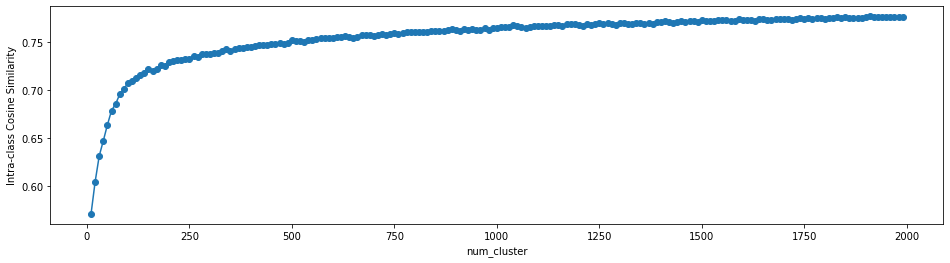

In [32]:
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=(16,4))
ax=plt.gca()
x = [i for i in range(10,2000,10)]

plt.plot(x,np.array(torch.tensor(num_classin_centers_loss).cpu().numpy()),marker='o')
plt.xlabel('num_cluster')
plt.ylabel('Intra-class Cosine Similarity')

Text(0, 0.5, 'Intra-class Cosine Similarity')

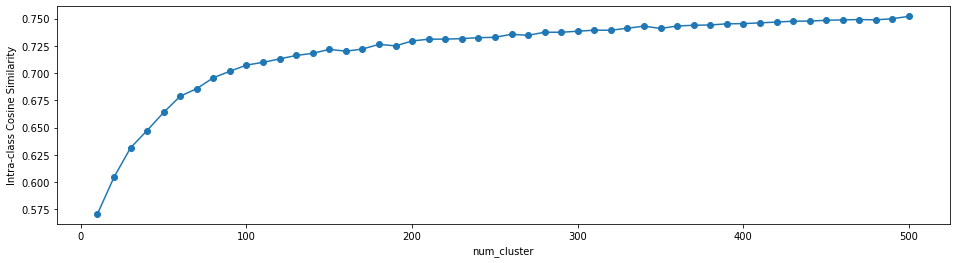

In [34]:
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=(16,4))
ax=plt.gca()
x = [i for i in range(10,510,10)]
num_classin_centers_loss_elbow =np.array(torch.tensor(num_classin_centers_loss).cpu().numpy())[:50]
plt.plot(x,num_classin_centers_loss_elbow,marker='o')
plt.xlabel('num_cluster')
plt.ylabel('Intra-class Cosine Similarity')

According to the Intra-class Cosine Similarity, the elbow is distributed from 100 to 120

## Step 4. Save cluster results and state

In [28]:
round1_stat_dict={}
round1_stat_dict['classin_centers_loss'] = np.array(torch.tensor(num_classin_centers_loss).cpu().numpy())
round1_stat_dict['codesori']=codesori_dict_round1
round1_stat_dict['centersori']=centersori_dict_round1
np.save('./exp/%s/task2_kmeans_round1_state.npy'%model_dir ,round1_stat_dict)

## Step 5. Annotate the pseudo label for training set

In [ ]:
# pseudo label
# codesori 100
f = open('./data/FFSVC2022/supplementary/round1_utt2spk_c100','w+')
for num,utt in enumerate(embd_dict.item()):
    f.write(utt+' '+str(codesori_dict_round1[100][num].cpu().numpy())+'\n')
    
f.close()

In [ ]:
f = open('./data/FFSVC2022/supplementary/round1_utt2spk_c110','w+')
for num,utt in enumerate(embd_dict.item()):
    f.write(utt+' '+str(codesori_dict_round1[110][num].cpu().numpy())+'\n')
    
f.close()

In [ ]:
f = open('./data/FFSVC2022/supplementary/round1_utt2spk_c120','w+')
for num,utt in enumerate(embd_dict.item()):
    f.write(utt+' '+str(codesori_dict_round1[120][num].cpu().numpy())+'\n')
    
f.close()

[INFO]NMI:  0.8498936114152992
[INFO]NMI:  0.8456232901801644
[INFO]NMI:  0.839822223871516
[INFO]NMI:  0.825807075552592


[INFO]purity:  0.8528746209297752
